In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from torch.utils.data import random_split, DataLoader, TensorDataset

import numpy as np

In [ ]:
# Loading and preprocessing data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
train_images = torch.tensor(train_images).unsqueeze(1)
train_labels = torch.tensor(train_labels)
test_images = torch.tensor(test_images).unsqueeze(1)
test_labels = torch.tensor(test_labels)

# Spliting training data into training and validation sets
train_dataset = TensorDataset(train_images, train_labels)
val_size = int(0.2 * len(train_dataset))  # 20% for validation
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=32, shuffle=False)


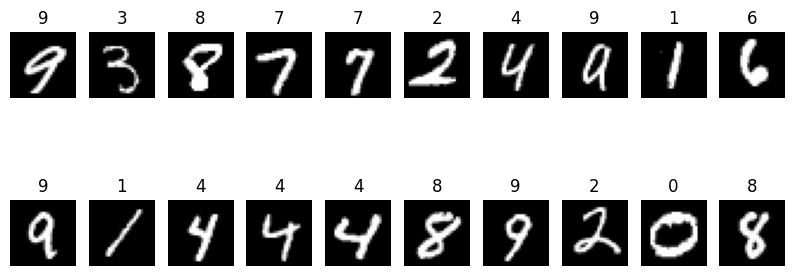

In [ ]:
# EDA - Visualizing some samples
def show_images(images, labels):
    plt.figure(figsize=(10, 4))
    for i in range(20):
        plt.subplot(2, 10, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(str(labels[i].item()))
        plt.axis('off')
    plt.show()

# Getting some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images, labels)



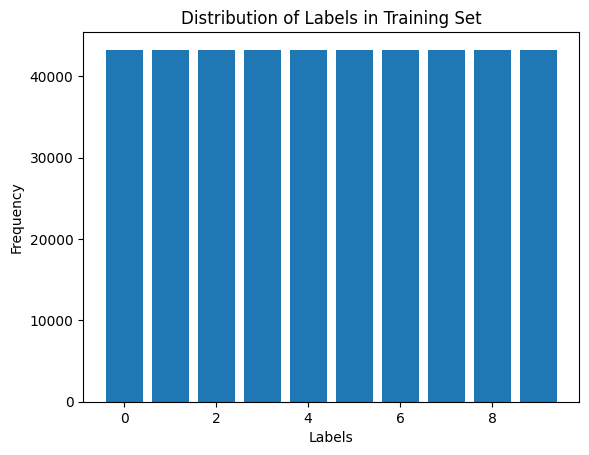

In [ ]:
# Checking label distribution
label_distribution = torch.zeros(10)
for _, label in train_dataset:
    label_distribution[label] += 1

plt.bar(range(10), label_distribution)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in Training Set')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Defining the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Output: 64x28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)       # Output: 64x14x14
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))   # Conv2 -> ReLU -> MaxPool
        x = x.view(-1, 64 * 7 * 7)             # Flatten
        x = F.relu(self.fc1(x))                # Fully connected layer 1
        x = self.fc2(x)                        # Fully connected layer 2
        return x


In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []

# Training the CNN
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy:.2f}%")

print('Finished Training')

Epoch 1/20, Loss: 0.16245161352609283, Val Loss: 0.05009585413771371, Val Accuracy: 98.46%
Epoch 2/20, Loss: 0.04917785497580189, Val Loss: 0.03866457189394472, Val Accuracy: 98.85%
Epoch 3/20, Loss: 0.0352686648881839, Val Loss: 0.040800513633759694, Val Accuracy: 98.89%
Epoch 4/20, Loss: 0.02523212747126915, Val Loss: 0.04069127989851404, Val Accuracy: 98.85%
Epoch 5/20, Loss: 0.019552319880559176, Val Loss: 0.03591311951034004, Val Accuracy: 98.96%
Epoch 6/20, Loss: 0.015841034860717626, Val Loss: 0.03495391942092101, Val Accuracy: 99.08%
Epoch 7/20, Loss: 0.011117468290054073, Val Loss: 0.0336641696545909, Val Accuracy: 99.12%
Epoch 8/20, Loss: 0.008535949626775884, Val Loss: 0.04253812424470076, Val Accuracy: 98.95%
Epoch 9/20, Loss: 0.009287095396397802, Val Loss: 0.04394185796483907, Val Accuracy: 98.94%
Epoch 10/20, Loss: 0.007085142000129911, Val Loss: 0.056507108952802206, Val Accuracy: 98.71%
Epoch 11/20, Loss: 0.007041381324152404, Val Loss: 0.04305372636444917, Val Accurac

In [ ]:
# Evaluating the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total:.2f}%")

Accuracy on the test set: 99.23%


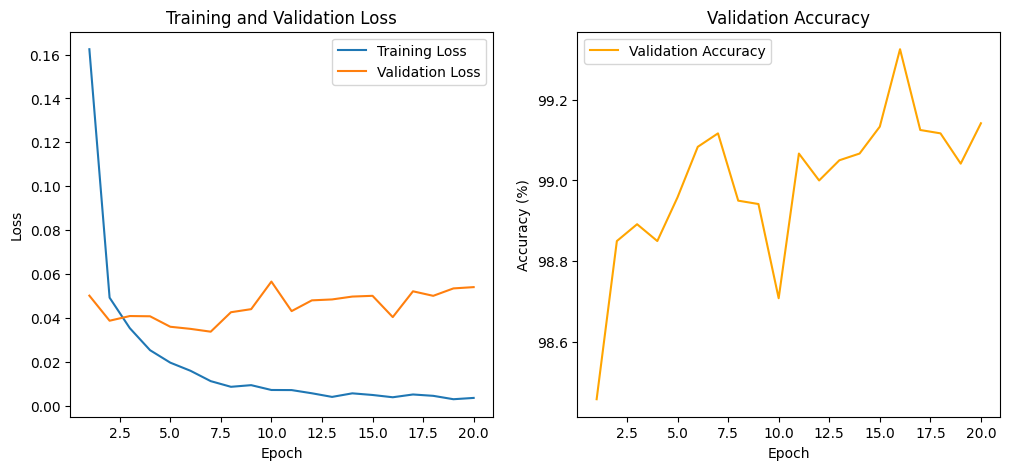

In [ ]:

# Visualization
# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

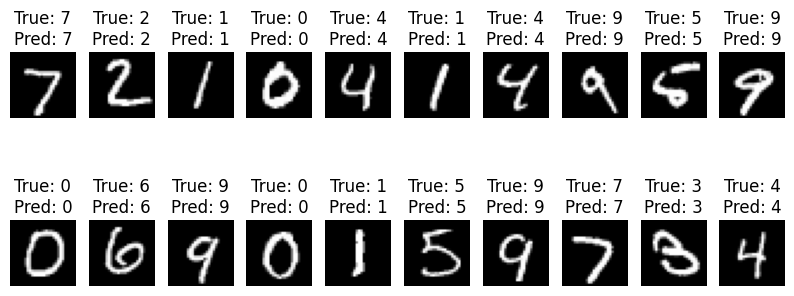

In [ ]:
# Visualizing some sample predictions
def show_predictions(images, labels, predictions):
    plt.figure(figsize=(10, 4))
    for i in range(20):
        plt.subplot(2, 10, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'True: {labels[i].item()}\nPred: {predictions[i].item()}')
        plt.axis('off')
    plt.show()

# Getting some predictions from the test set
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

show_predictions(images, labels, predictions)